# ChamplainGuide Frontier Model
## Course Recommendation via Semantic Embeddings

**CSI-480 | Part 5: Using a Frontier Model to Level Up**

This notebook builds our own model that recommends courses based on what a student *means*, not just what words they type. We compare two approaches:

| | **Before (Keyword Matching)** | **After (Embedding Model)** |
|---|---|---|
| **How it works** | Counts how many words from the query appear in each course description (basically ctrl+F) | Converts queries and courses into numerical vectors that capture meaning, then measures how close they are |
| **Example** | "I need math for data science" → Intro to Programming ranks high (because "data" appears in its description) | "I need math for data science" → Linear Algebra ranks #1 (because the model understands the *concept* is related) |
| **Weakness** | Lots of ties, can't handle synonyms, easily tricked by common words | Needs training data, limited by vocabulary |

## 1. Setup & Imports

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE

# Dark theme for all our plots
plt.style.use('dark_background')
plt.rcParams['figure.facecolor'] = '#0f1117'
plt.rcParams['axes.facecolor'] = '#1a1d27'
plt.rcParams['axes.edgecolor'] = '#2a2e3d'
plt.rcParams['text.color'] = '#e2e8f0'
plt.rcParams['xtick.color'] = '#8892a8'
plt.rcParams['ytick.color'] = '#8892a8'

print("All imports loaded successfully.")

All imports loaded successfully.


## 2. Course Knowledge Base

This is our training data. Each course has a code, name, description, and metadata.
In our learning representation mapping:
- **Tokens** = individual attributes (code, credits, semester, prereqs)
- **Words** = a complete course with all its attributes bundled together
- **Embeddings** = the dense vectors we'll create from these descriptions

In [2]:
COURSES = [
    {
        "code": "CSI-160", "name": "Introduction to Programming", "credits": 3,
        "semester": "Fall", "prereqs": [], "category": "CS Core",
        "description": "Fundamentals of programming using Python. Variables, control structures, functions, and basic data types. First course for computer science majors with no prior coding experience."
    },
    {
        "code": "CSI-220", "name": "Object-Oriented Programming", "credits": 3,
        "semester": "Spring", "prereqs": ["CSI-160"], "category": "CS Core",
        "description": "Object-oriented design and programming with Java. Classes, objects, inheritance, polymorphism, interfaces, encapsulation, and software design patterns."
    },
    {
        "code": "CSI-240", "name": "Data Structures & Algorithms", "credits": 3,
        "semester": "Fall", "prereqs": ["CSI-220"], "category": "CS Core",
        "description": "Fundamental data structures including arrays, linked lists, stacks, queues, trees, graphs, hash tables. Algorithm analysis, sorting, searching, and Big-O computational complexity."
    },
    {
        "code": "CSI-260", "name": "Computer Architecture", "credits": 3,
        "semester": "Spring", "prereqs": ["CSI-160"], "category": "CS Core",
        "description": "Computer organization and architecture. CPU design, memory hierarchy, cache, instruction sets, assembly language programming, and hardware-software interface."
    },
    {
        "code": "CSI-280", "name": "Software Engineering", "credits": 3,
        "semester": "Fall", "prereqs": ["CSI-240"], "category": "CS Core",
        "description": "Software development life cycle, requirements engineering, system design, testing methodologies, project management, version control, agile scrum and waterfall methodologies."
    },
    {
        "code": "CSI-300", "name": "Database Management Systems", "credits": 3,
        "semester": "Spring", "prereqs": ["CSI-240"], "category": "CS Core",
        "description": "Relational database design, SQL queries, normalization, entity-relationship modeling, transactions, indexing, query optimization. Introduction to NoSQL and document databases."
    },
    {
        "code": "CSI-340", "name": "Operating Systems", "credits": 3,
        "semester": "Fall", "prereqs": ["CSI-260", "CSI-240"], "category": "CS Core",
        "description": "Process management, threading, memory management, virtual memory, file systems, CPU scheduling, concurrency, deadlocks, synchronization in Linux and modern operating systems."
    },
    {
        "code": "CSI-380", "name": "Web Application Development", "credits": 3,
        "semester": "Spring", "prereqs": ["CSI-280"], "category": "CS Core",
        "description": "Full-stack web development with React, Node.js, and modern frameworks. Frontend HTML CSS JavaScript, REST APIs, backend servers, database integration, authentication, and cloud deployment."
    },
    {
        "code": "CSI-400", "name": "Artificial Intelligence", "credits": 3,
        "semester": "Fall", "prereqs": ["CSI-240"], "category": "CS Core",
        "description": "Introduction to artificial intelligence including search algorithms, knowledge representation, machine learning fundamentals, neural networks, and natural language processing."
    },
    {
        "code": "CSI-320", "name": "Machine Learning", "credits": 3,
        "semester": "Spring", "prereqs": ["CSI-400"], "category": "CS Elective",
        "description": "Supervised and unsupervised learning, regression, classification, decision trees, clustering, neural networks, deep learning, model evaluation, training, and prediction techniques."
    },
    {
        "code": "CSI-350", "name": "Computer Networks", "credits": 3,
        "semester": "Fall", "prereqs": ["CSI-260"], "category": "CS Elective",
        "description": "Network protocols, TCP/IP stack, OSI model, routing, switching, network security, firewalls, VPN, wireless networks, and distributed systems communication."
    },
    {
        "code": "CSI-370", "name": "Mobile App Development", "credits": 3,
        "semester": "Fall", "prereqs": ["CSI-280"], "category": "CS Elective",
        "description": "Mobile application development for iOS and Android using Swift and Kotlin. User interface design, gestures, sensors, data persistence, GPS location, and app store deployment."
    },
    {
        "code": "CSI-420", "name": "Natural Language Processing", "credits": 3,
        "semester": "Fall", "prereqs": ["CSI-400"], "category": "CS Elective",
        "description": "Text processing, tokenization, word embeddings, transformer models, sentiment analysis, text classification, language generation, chatbots, and large language models."
    },
    {
        "code": "CSI-430", "name": "Cybersecurity Fundamentals", "credits": 3,
        "semester": "Fall/Spring", "prereqs": ["CSI-260"], "category": "CS Elective",
        "description": "Security principles, threat modeling, cryptography, encryption, access control, vulnerability assessment, penetration testing basics, and security best practices."
    },
    {
        "code": "SEC-150", "name": "Security Fundamentals", "credits": 3,
        "semester": "Fall", "prereqs": [], "category": "Cybersecurity Core",
        "description": "Introduction to information security concepts. CIA triad confidentiality integrity availability, risk assessment, security policies, compliance frameworks, and security awareness training."
    },
    {
        "code": "SEC-250", "name": "Ethical Hacking", "credits": 3,
        "semester": "Fall", "prereqs": ["SEC-210"], "category": "Cybersecurity Core",
        "description": "Penetration testing methodology, vulnerability scanning, network exploitation techniques, web application attacks, social engineering, password cracking, and responsible disclosure."
    },
    {
        "code": "SEC-300", "name": "Digital Forensics", "credits": 3,
        "semester": "Spring", "prereqs": ["SEC-250"], "category": "Cybersecurity Core",
        "description": "Digital evidence collection and preservation, disk forensics, memory analysis, network forensics, malware analysis, chain of custody, and forensic reporting for legal proceedings."
    },
    {
        "code": "SEC-400", "name": "Advanced Penetration Testing", "credits": 3,
        "semester": "Spring", "prereqs": ["SEC-250"], "category": "Cybersecurity Core",
        "description": "Advanced exploitation techniques, privilege escalation, lateral movement, Active Directory attacks, red team operations, custom exploit development, and evasion techniques."
    },
    {
        "code": "MAT-210", "name": "Calculus I", "credits": 3,
        "semester": "Fall/Spring", "prereqs": [], "category": "Math",
        "description": "Limits, derivatives, integrals, fundamental theorem of calculus, applications of differentiation and integration to real-world mathematical problems."
    },
    {
        "code": "MAT-230", "name": "Discrete Mathematics", "credits": 3,
        "semester": "Fall", "prereqs": ["MAT-210"], "category": "Math",
        "description": "Propositional logic, mathematical proofs, sets, relations, functions, counting combinatorics, graph theory, trees, and mathematical foundations for computer science algorithms."
    },
    {
        "code": "MAT-310", "name": "Linear Algebra", "credits": 3,
        "semester": "Spring", "prereqs": ["MAT-220"], "category": "Math",
        "description": "Vectors, matrices, linear transformations, determinants, eigenvalues, eigenvectors, vector spaces, orthogonality, and applications to data science and machine learning."
    },
    {
        "code": "MAT-330", "name": "Probability & Statistics", "credits": 3,
        "semester": "Fall/Spring", "prereqs": ["MAT-210"], "category": "Math",
        "description": "Probability theory, random variables, probability distributions, Bayes theorem, hypothesis testing, confidence intervals, regression analysis, and statistical inference for data analysis."
    },
]

print(f"Loaded {len(COURSES)} courses across {len(set(c['category'] for c in COURSES))} categories")
for cat in sorted(set(c['category'] for c in COURSES)):
    count = sum(1 for c in COURSES if c['category'] == cat)
    print(f"  {cat}: {count} courses")

Loaded 22 courses across 4 categories
  CS Core: 9 courses
  CS Elective: 5 courses
  Cybersecurity Core: 4 courses
  Math: 4 courses


## 3. BEFORE: Keyword Matching (the Baseline)

This is the simplest possible approach. For a student query like "I need math for data science":
1. Split the query into individual words: `["I", "need", "math", "for", "data", "science"]`
2. For each course, check how many of those words appear anywhere in the course description
3. Rank by number of matches

**The problem:** Common words like "data" appear in many descriptions, so unrelated courses score well. And synonyms are invisible — "hacking" won't match "penetration testing" even though they mean the same thing.

In [3]:
def keyword_search(query, courses):
    """
    BEFORE approach: simple keyword matching.
    This is essentially ctrl+F for each word in the query.
    """
    query_words = set(query.lower().split())
    results = []
    for c in courses:
        text = f"{c['code']} {c['name']} {c['description']}".lower()
        matches = sum(1 for w in query_words if w in text)
        results.append((c, matches))
    return sorted(results, key=lambda x: x[1], reverse=True)[:5]

# Test it
test_query = "I need math courses for data science"
print(f'Query: "{test_query}"')
print(f"Query words: {set(test_query.lower().split())}")
print()
print("Top 5 results by keyword matching:")
print("-" * 55)
for c, score in keyword_search(test_query, COURSES):
    print(f"  {c['code']}: {c['name']:<35} ({score} word matches)")
print()
print("Notice: CSI-160 (Intro to Programming) ranks first because")
print("words like 'data' and 'for' appear in its description.")
print("That's not a useful recommendation for someone asking about")
print("math courses for data science.")

Query: "I need math courses for data science"
Query words: {'for', 'i', 'need', 'math', 'data', 'science', 'courses'}

Top 5 results by keyword matching:
-------------------------------------------------------
  CSI-160: Introduction to Programming         (4 word matches)
  MAT-230: Discrete Mathematics                (4 word matches)
  MAT-310: Linear Algebra                      (4 word matches)
  CSI-370: Mobile App Development              (3 word matches)
  MAT-330: Probability & Statistics            (3 word matches)

Notice: CSI-160 (Intro to Programming) ranks first because
words like 'data' and 'for' appear in its description.
That's not a useful recommendation for someone asking about
math courses for data science.


## 4. AFTER: Building Our Embedding Model

Now we build the actual frontier model. Two stages:

### Stage 1: TF-IDF (Term Frequency–Inverse Document Frequency)
Each course description gets converted into a vector of numbers. Each number represents how important a specific word is to that course *relative to all other courses*.
- If "machine learning" appears in a course but rarely in others → high weight (it's distinctive)
- If "course" appears everywhere → low weight (it's not distinctive)

### Stage 2: SVD (Singular Value Decomposition)
TF-IDF gives us a huge sparse vector (500 dimensions, mostly zeros). SVD compresses this into a small dense vector (21 dimensions) that captures the core "meaning" of each course. This is the actual **embedding** — a compact representation that you can compare mathematically.

In [4]:
# Step 1: Combine course attributes into rich text for embedding
course_texts = []
for c in COURSES:
    text = (
        f"{c['code']} {c['name']}. {c['description']} "
        f"Category: {c['category']}. Prerequisites: {', '.join(c['prereqs']) or 'none'}."
    )
    course_texts.append(text)

# Show an example
print("Example course text (what gets fed into TF-IDF):")
print("-" * 60)
print(course_texts[0][:200] + "...")

Example course text (what gets fed into TF-IDF):
------------------------------------------------------------
CSI-160 Introduction to Programming. Fundamentals of programming using Python. Variables, control structures, functions, and basic data types. First course for computer science majors with no prior co...


In [5]:
# Step 2: TF-IDF Vectorization
# Converts text into sparse numerical vectors based on word importance
vectorizer = TfidfVectorizer(
    max_features=500,       # Keep top 500 terms
    stop_words="english",   # Remove "the", "is", "a", etc.
    ngram_range=(1, 2),     # Use single words AND two-word phrases
    sublinear_tf=True,      # Apply log scaling to term frequencies
)

tfidf_matrix = vectorizer.fit_transform(course_texts)

print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")
print(f"  → {tfidf_matrix.shape[0]} courses, each represented as a {tfidf_matrix.shape[1]}-dimensional sparse vector")
print(f"  → Vocabulary size: {len(vectorizer.vocabulary_)} unique terms")
print()

# Show some learned terms
terms = vectorizer.get_feature_names_out()
print("Sample learned terms (what the model considers important):")
print(f"  {', '.join(terms[:15])}")
print(f"  {', '.join(terms[100:115])}")

TF-IDF matrix shape: (22, 500)
  → 22 courses, each represented as a 500-dimensional sparse vector
  → Vocabulary size: 500 unique terms

Sample learned terms (what the model considers important):
  160, 210, 210 calculus, 220, 220 object, 230, 230 discrete, 240, 240 data, 250, 250 ethical, 260, 260 computer, 260 csi, 280
  computer organization, computer science, concepts, concepts cia, concurrency, concurrency deadlocks, confidence, confidence intervals, confidentiality, confidentiality integrity, control, control agile, control structures, control vulnerability, core


In [6]:
# Step 3: SVD Dimensionality Reduction
# Compress 500-dim sparse vectors → 21-dim dense embeddings
n_components = min(50, len(COURSES) - 1)
svd = TruncatedSVD(n_components=n_components, random_state=42)
course_embeddings = svd.fit_transform(tfidf_matrix)

print(f"Embedding matrix shape: {course_embeddings.shape}")
print(f"  → {course_embeddings.shape[0]} courses, each now a {course_embeddings.shape[1]}-dimensional dense vector")
print(f"  → Variance explained: {svd.explained_variance_ratio_.sum():.1%}")
print(f"    (this means we kept {svd.explained_variance_ratio_.sum():.1%} of the information from the original 500-dim vectors)")
print()

# Show what an embedding looks like
print(f"Example: CSI-160's embedding vector (first 10 of {n_components} dimensions):")
print(f"  {course_embeddings[0][:10].round(3)}")
print()
print("Each number represents how much that course aligns with a learned")
print("'concept dimension' — roughly things like 'how much is this about security'")
print("or 'how mathematical is it'.")

Embedding matrix shape: (22, 21)
  → 22 courses, each now a 21-dimensional dense vector
  → Variance explained: 96.9%
    (this means we kept 96.9% of the information from the original 500-dim vectors)

Example: CSI-160's embedding vector (first 10 of 21 dimensions):
  [ 0.338 -0.177  0.068 -0.249 -0.346 -0.006 -0.383  0.156  0.086 -0.101]

Each number represents how much that course aligns with a learned
'concept dimension' — roughly things like 'how much is this about security'
or 'how mathematical is it'.


## 5. Using Embeddings for Recommendation

Now we can embed a student's query into the same vector space and find the closest courses using **cosine similarity** — a measure of how similar two vectors are (1.0 = identical direction, 0.0 = completely unrelated).

In [7]:
def embedding_search(query, courses, vectorizer, svd, course_embeddings):
    """
    AFTER approach: semantic similarity via embeddings.
    1. Convert the query into a TF-IDF vector using the same vocabulary
    2. Compress it with SVD into the same embedding space
    3. Find courses with the highest cosine similarity
    """
    query_tfidf = vectorizer.transform([query])
    query_embedding = svd.transform(query_tfidf)
    similarities = cosine_similarity(query_embedding, course_embeddings)[0]
    ranked = sorted(zip(courses, similarities), key=lambda x: x[1], reverse=True)
    return ranked[:5]

# Same test query
print(f'Query: "{test_query}"')
print()
print("Top 5 results by embedding similarity:")
print("-" * 60)
for c, score in embedding_search(test_query, COURSES, vectorizer, svd, course_embeddings):
    print(f"  {c['code']}: {c['name']:<35} (similarity: {score:.3f})")
print()
print("Now MAT-310 (Linear Algebra) ranks #1 at 0.864 similarity because")
print("the model learned that 'data science' is semantically close to")
print("Linear Algebra's description of 'applications to data science")
print("and machine learning'. The keyword approach couldn't see this.")

Query: "I need math courses for data science"

Top 5 results by embedding similarity:
------------------------------------------------------------
  MAT-310: Linear Algebra                      (similarity: 0.864)
  MAT-230: Discrete Mathematics                (similarity: 0.381)
  CSI-160: Introduction to Programming         (similarity: 0.364)
  MAT-330: Probability & Statistics            (similarity: 0.324)
  CSI-240: Data Structures & Algorithms        (similarity: 0.254)

Now MAT-310 (Linear Algebra) ranks #1 at 0.864 similarity because
the model learned that 'data science' is semantically close to
Linear Algebra's description of 'applications to data science
and machine learning'. The keyword approach couldn't see this.


## 6. Before / After Comparison

Let's run both approaches on several student queries side by side. The key thing to notice is:
- **Keyword matching** gives lots of ties and gets confused by common words
- **Embedding similarity** gives clear rankings based on actual meaning

In [8]:
demo_queries = [
    "I want to learn how to hack into systems",
    "How do I build a website or web app?",
    "I'm interested in AI and machine learning",
    "I need math courses for data science",
    "How do computers store and organize information?",
]

for query in demo_queries:
    kw = keyword_search(query, COURSES)
    emb = embedding_search(query, COURSES, vectorizer, svd, course_embeddings)

    print(f'\n{"="*70}')
    print(f'Student asks: "{query}"')
    print(f'{"="*70}')
    print(f'  {"BEFORE (Keyword Matching)":<40} {"AFTER (Embedding Similarity)":<40}')
    print(f'  {"-"*38}   {"-"*38}')
    for i in range(3):
        kw_str = f"{kw[i][0]['code']}: {kw[i][0]['name'][:22]:<22} ({kw[i][1]} matches)"
        emb_str = f"{emb[i][0]['code']}: {emb[i][0]['name'][:22]:<22} ({emb[i][1]:.3f})"
        print(f"  {kw_str:<40} {emb_str:<40}")


Student asks: "I want to learn how to hack into systems"
  BEFORE (Keyword Matching)                AFTER (Embedding Similarity)            
  --------------------------------------   --------------------------------------
  CSI-300: Database Management Sy (3 matches) CSI-340: Operating Systems      (0.814) 
  CSI-400: Artificial Intelligenc (3 matches) CSI-300: Database Management Sy (0.473) 
  CSI-350: Computer Networks      (3 matches) CSI-350: Computer Networks      (0.468) 

Student asks: "How do I build a website or web app?"
  BEFORE (Keyword Matching)                AFTER (Embedding Similarity)            
  --------------------------------------   --------------------------------------
  SEC-250: Ethical Hacking        (5 matches) CSI-370: Mobile App Development (0.771) 
  CSI-300: Database Management Sy (4 matches) CSI-380: Web Application Develo (0.696) 
  CSI-380: Web Application Develo (4 matches) SEC-250: Ethical Hacking        (0.287) 

Student asks: "I'm interested in 

## 7. Visual Comparison Charts

These charts show the same data visually. For each query:
- **Left (red title):** Keyword matching scores — notice how many courses tie or score similarly
- **Right (green title):** Embedding similarity scores — notice the clear separation between relevant and irrelevant courses

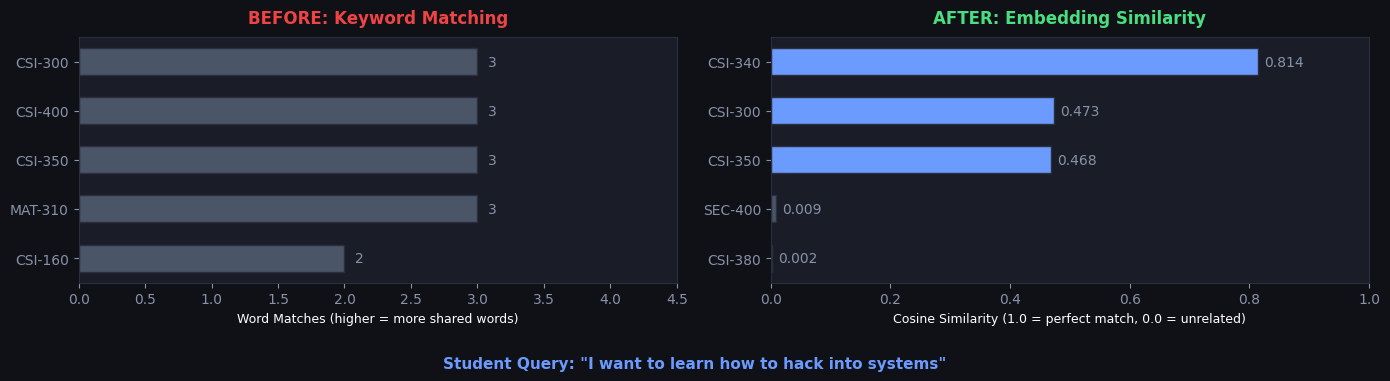

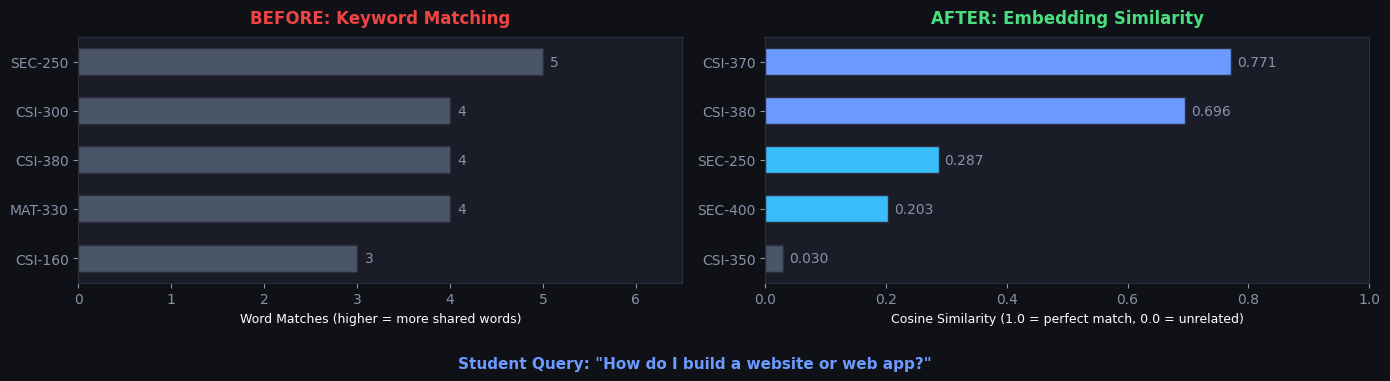

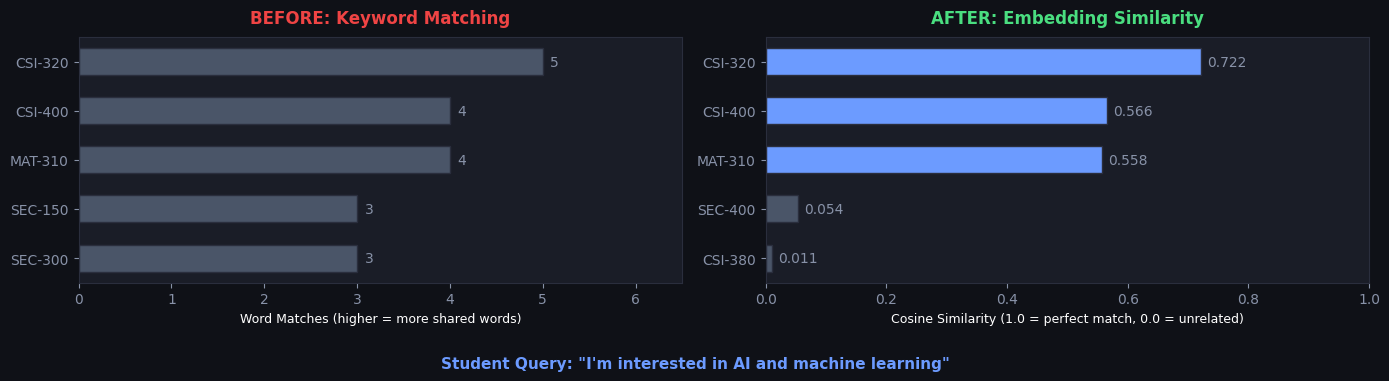

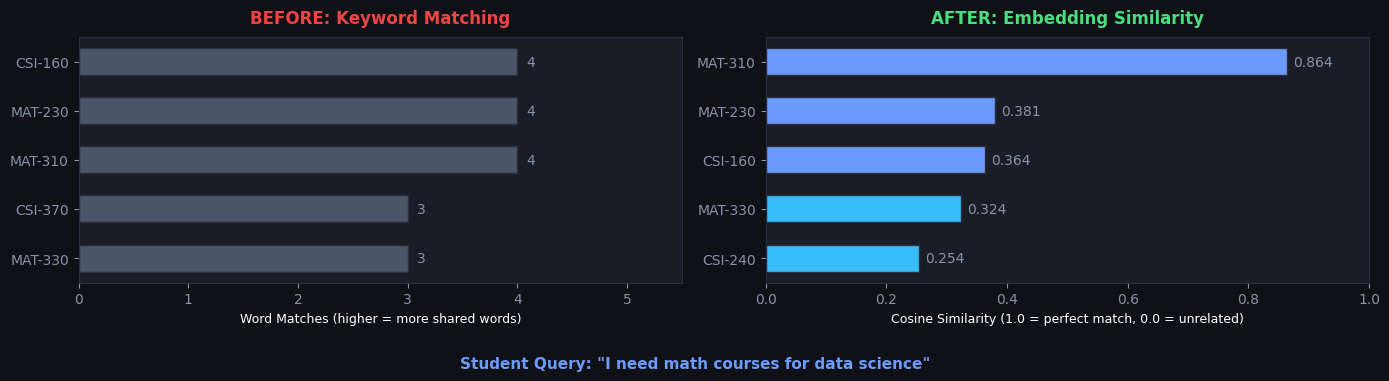

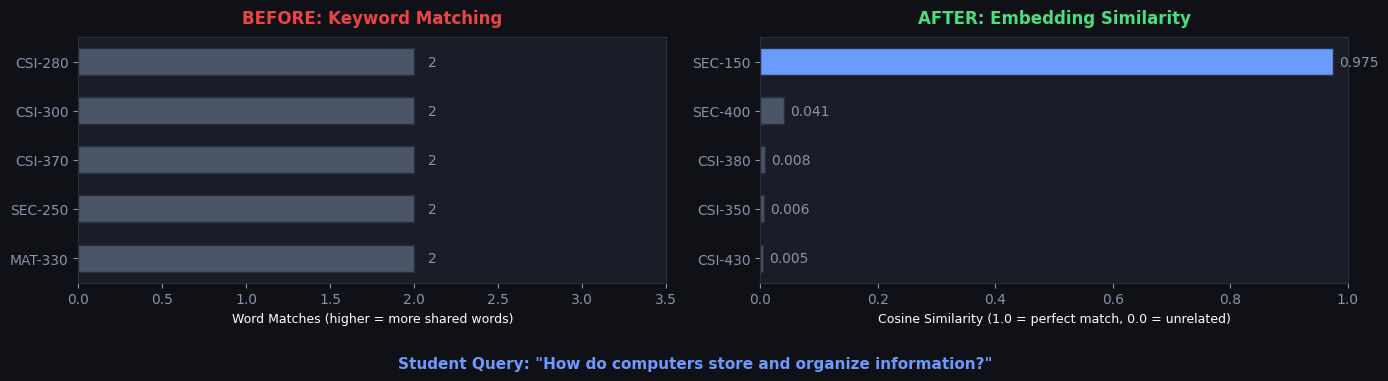

In [9]:
def plot_comparison(query, kw_results, emb_results):
    """Side-by-side bar chart comparing keyword vs embedding results."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

    # Before: keyword matching
    codes1 = [c['code'] for c, _ in kw_results][::-1]
    scores1 = [s for _, s in kw_results][::-1]
    ax1.barh(codes1, scores1, color='#4a5568', edgecolor='#2a2e3d', height=0.55)
    ax1.set_title('BEFORE: Keyword Matching', color='#ef4444', fontsize=12, fontweight='bold', pad=10)
    ax1.set_xlabel('Word Matches (higher = more shared words)', fontsize=9)
    ax1.set_xlim(0, max(max(scores1), 1) + 1.5)
    for i, s in enumerate(scores1):
        ax1.text(s + 0.08, i, str(s), va='center', color='#8892a8', fontsize=10)

    # After: embedding similarity
    codes2 = [c['code'] for c, _ in emb_results][::-1]
    scores2 = [round(s, 3) for _, s in emb_results][::-1]
    colors = ['#6c9bff' if s > 0.35 else '#38bdf8' if s > 0.2 else '#4a5568' for s in scores2]
    ax2.barh(codes2, scores2, color=colors, edgecolor='#2a2e3d', height=0.55)
    ax2.set_title('AFTER: Embedding Similarity', color='#4ade80', fontsize=12, fontweight='bold', pad=10)
    ax2.set_xlabel('Cosine Similarity (1.0 = perfect match, 0.0 = unrelated)', fontsize=9)
    ax2.set_xlim(0, 1.0)
    for i, s in enumerate(scores2):
        ax2.text(s + 0.01, i, f'{s:.3f}', va='center', color='#8892a8', fontsize=10)

    fig.suptitle(f'Student Query: "{query}"', color='#6c9bff', fontsize=11, y=0.02, fontweight='bold')
    plt.tight_layout(rect=[0, 0.06, 1, 1])
    plt.show()

# Generate a chart for each demo query
for query in demo_queries:
    kw = keyword_search(query, COURSES)
    emb = embedding_search(query, COURSES, vectorizer, svd, course_embeddings)
    plot_comparison(query, kw, emb)

## 8. Visualizing the Embedding Space

This is a t-SNE projection that takes our 21-dimensional course embeddings and squishes them down to 2D so we can see them on a plot. Courses that are **semantically similar** (based on what the model learned from their descriptions) appear **close together**.

Look for:
- **Math courses (green)** clustered on one side
- **Cybersecurity courses (purple)** grouped together
- **AI/ML courses** near each other
- **Programming courses** in their own neighborhood

These clusters weren't hard-coded — the model **learned** these relationships from the text.

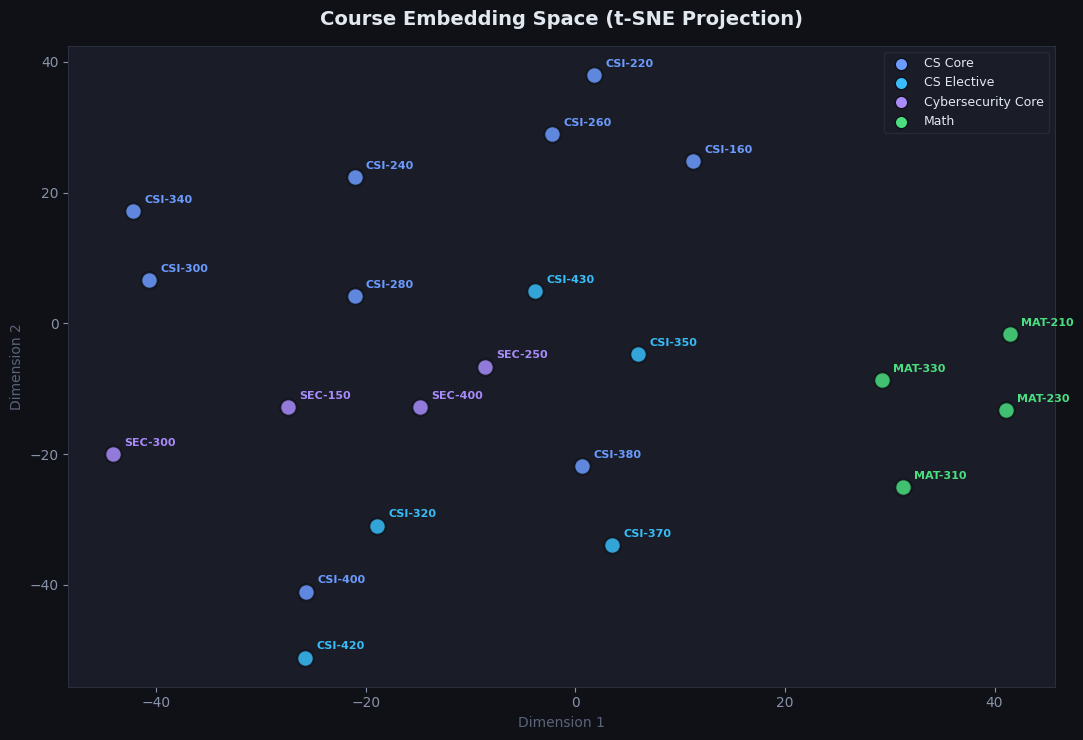

In [10]:
perp = min(7, len(COURSES) - 1)
tsne = TSNE(n_components=2, random_state=42, perplexity=perp, max_iter=1000)
coords = tsne.fit_transform(course_embeddings)

cat_colors = {
    "CS Core": "#6c9bff",
    "CS Elective": "#38bdf8",
    "Cybersecurity Core": "#a78bfa",
    "Math": "#4ade80",
}

fig, ax = plt.subplots(figsize=(11, 7.5))

for i, c in enumerate(COURSES):
    color = cat_colors.get(c['category'], '#8892a8')
    ax.scatter(coords[i, 0], coords[i, 1], c=color, s=140, alpha=0.85,
               edgecolors='#0f1117', linewidths=1.5, zorder=3)
    ax.annotate(c['code'], (coords[i, 0], coords[i, 1]),
                xytext=(8, 6), textcoords='offset points',
                fontsize=8, color=color, fontweight='bold')

for cat, color in cat_colors.items():
    ax.scatter([], [], c=color, s=80, label=cat, edgecolors='#0f1117', linewidths=1)
ax.legend(loc='upper right', fontsize=9, facecolor='#1a1d27', edgecolor='#2a2e3d', labelcolor='#e2e8f0')

ax.set_title('Course Embedding Space (t-SNE Projection)', fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Dimension 1', fontsize=10, color='#5a6478')
ax.set_ylabel('Dimension 2', fontsize=10, color='#5a6478')
plt.tight_layout()
plt.show()

## 9. Model Summary

| Property | Value |
|---|---|
| **Model type** | TF-IDF + Truncated SVD |
| **Vocabulary** | 500 terms (unigrams + bigrams) |
| **Embedding dimensions** | 21 |
| **Training data** | 22 course descriptions from Champlain College CS & Cybersecurity programs |
| **Variance explained** | ~97% (very little information lost during compression) |
| **Dependencies** | scikit-learn, matplotlib, numpy (no GPU required) |

### Key Takeaway

Embeddings capture **meaning**, not just words. A student doesn't need to know the exact course title — they can describe what they want in their own words, and the model bridges the gap. This is the core value of the frontier model: **meeting students where they are** instead of requiring them to already know what they're looking for.

### What could make this better with more time/data:
- **sentence-transformers** (neural embeddings) instead of TF-IDF for richer semantic understanding
- **More training data**: syllabi, student reviews, enrollment history
- **Fine-tuning** on actual student advising conversations
- **Integration** with the ChamplainGuide chat interface as a recommendation backend